# Summary

----


# Imports

In [1]:
NOTEBOOK_NAME = 'protherm'

In [2]:
%run common_imports.ipynb

2016-05-05 19:11:53.542245


# Extract

In [3]:
ls ../downloads/

abdellah_2009.tsv.gz  kineticdb.html  ProTherm.dat.gz
kineticdb2.html       pfd_all.html    rosetta_ddg.zip
kineticdb_all.html    pfd.html        small_studies.ods


In [4]:
mkdir -p $NOTEBOOK_NAME

In [5]:
!7za x -y -bb0 -bd -o"$NOTEBOOK_NAME" ../downloads/ProTherm.dat.gz


7-Zip (a) [64] 15.09 beta : Copyright (c) 1999-2015 Igor Pavlov : 2015-10-16
p7zip Version 15.09 beta (locale=en_CA.UTF-8,Utf16=on,HugeFiles=on,64 bits,64 CPUs x64)

Scanning the drive for archives:
1 file, 1496602 bytes (1462 KiB)

Extracting archive: ../downloads/ProTherm.dat.gz
--
Path = ../downloads/ProTherm.dat.gz
Type = gzip
Headers Size = 23

Everything is Ok

Size:       48550543
Compressed: 1496602


# Load ProTherm

In [6]:
# Parse protherm into entry chunks
protherm_filename_full = '../downloads/ProTherm.dat.gz'
with gzip.open(protherm_filename_full, 'rt', encoding='cp437') as ifh:
    file_data_chunks = [x.strip() for x in ifh.read().split('//')]

In [7]:
# Convert entry chunks into rows and combine
COLUMNS = []

def get_unique_columns(columns):
    seen = set()
    for c in columns:
        i, c_orig = 0, i
        while c in seen:
            i += 1
            c = c_orig + '_{}'.format(i)
        seen.add(c)
        yield c

def convert_chunks_to_rows(file_data_chunks):
    global COLUMNS
    for i in range(len(file_data_chunks)):
        # Don't return an empty dict for an empty chunk
        if not file_data_chunks[i].strip(' \n'):
            continue
        column = None
        column_old = None
        columns = []
        row = defaultdict(list)
        for line in file_data_chunks[i].split('\n'):
            if line.startswith('***'):
                continue
            column_old = column if column else column_old
            column = line.split(' ')[0]
            column_version = 1
            while column in columns:
                column_version += 1
                column = line.split(' ')[0] + '_{}'.format(column_version)
            value = ' '.join(line.split(' ')[1:]).strip(' \n')
            if not column:
                if not column_old or not value:
                    error_message = (
                        'i: {}, line: {}, column: {}, column_old: {}, value: {}'.format(
                            i, line, column, column_old, value))
                    raise Exception(error_message)
                row[column_old][-1] += ' ' + value
            else:
                row[column].append(value)
                columns.append(column)
        if len(columns) > len(COLUMNS):
            COLUMNS = columns
        yield {key: ','.join(values) for (key, values) in row.items()}

rows = list(convert_chunks_to_rows(file_data_chunks))
df = pd.DataFrame(rows, columns=COLUMNS)

In [8]:
', '.join(COLUMNS)

'NO., PROTEIN, SOURCE, LENGTH, MOL-WEIGHT, PIR_ID, SWISSPROT_ID, E.C.NUMBER, PMD.NO, PDB_wild, PDB_mutant, MUTATION, MUTATED_CHAIN, NO_MOLECULE, SEC.STR., ASA, T, pH, BUFFER_NAME, BUFFER_CONC, ION_NAME_1, ION_CONC_1, ADDITIVES, PROTEIN_CONC, MEASURE, METHOD, dG_H2O, ddG_H2O, dG, ddG, Tm, dTm, dHvH, dHcal, m, Cm, dCp, STATE, REVERSIBILITY, ACTIVITY, ACTIVITY_Km, ACTIVITY_Kcat, ACTIVITY_Kd, REVERSIBILITY_2, ACTIVITY_2, ACTIVITY_Km_2, ACTIVITY_Kcat_2, ACTIVITY_Kd_2, KEY_WORDS, REFERENCE, AUTHOR, REMARKS, RELATED_ENTRIES'

In [9]:
renames = {'E.C.NUMBER': 'ec_number'}
df = df.rename(columns=lambda x: x.replace('.', '_').replace('-', '_').strip('_').lower())

In [10]:
', '.join(df.columns)

'no, protein, source, length, mol_weight, pir_id, swissprot_id, e_c_number, pmd_no, pdb_wild, pdb_mutant, mutation, mutated_chain, no_molecule, sec_str, asa, t, ph, buffer_name, buffer_conc, ion_name_1, ion_conc_1, additives, protein_conc, measure, method, dg_h2o, ddg_h2o, dg, ddg, tm, dtm, dhvh, dhcal, m, cm, dcp, state, reversibility, activity, activity_km, activity_kcat, activity_kd, reversibility_2, activity_2, activity_km_2, activity_kcat_2, activity_kd_2, key_words, reference, author, remarks, related_entries'

In [11]:
df.head()

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,,wild,-,1,,,30.0,8.0,borate,10 mM,,,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,,,,,,,,1.47,6.90,,,Unknown,,1.4,675,,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,"
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,,,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,,,,,,,1.20,5.40,,,Unknown,,2.6,0.04,,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,"
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,,,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,,,,,,,1.34,6.60,,,Unknown,,,undetectable (<0.001),,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,"
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,,,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,,,,,,,1.02,6.30,,,Unknown,,,undetectable (<0.001),,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,"
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,,wild,-,1,,,,3.00,glycine-HCl,10 mM,,,,,CD,Thermal,,,,,49.8,0.0,98.1,,,,,,yes,100,,,,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21..."


In [12]:
print(df.shape)

(25829, 53)


In [13]:
# Replace empty strings with NaNs and remove all-empty rows
df[df == ''] = np.nan
df = df.dropna(subset=['no'])
print(df.shape)

(25823, 53)


In [14]:
df = df[~((df['pdb_wild'] == '1OTR') & (df['mutation'].str.startswith('A 33')))]
print(df.shape)

(25703, 53)


In [15]:
display(df.head(2))

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,"
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,"


In [16]:
def parse_swissprot_id(swissprot_id):
    """
    """
    uniprot_name_conversion = {
        'MK10_HUMAN': 'BRCA1_HUMAN',  # BRCA1
    }
    uniprot_id_conversion = {
        'P69542': 'P69543',
        'P53779': 'P38398',  # BRCA1
    }
    #
    if pd.isnull(swissprot_id):
        return np.nan, np.nan
    row = list(filter(lambda x: x, map(lambda x: x.strip(' ()'), swissprot_id.split())))
    if len(row) == 0:
        uniprot_name, uniprot_id = None, None
    elif len(row) == 1:
        uniprot_name, uniprot_id = row[0], None
    elif len(row) == 2:
        uniprot_name, uniprot_id = row
    else:
        raise Exception('Unknown row: {}, swissprot_id: {}'.format(row, swissprot_id))
    uniprot_name = uniprot_name_conversion.get(uniprot_name, uniprot_name)
    uniprot_id = uniprot_id_conversion.get(uniprot_id, uniprot_id)
    return uniprot_name, uniprot_id

df['uniprot_name_protherm'], df['uniprot_id_protherm'] = zip(*df['swissprot_id'].apply(parse_swissprot_id))

In [17]:
df['protein_name'] = df['protein']

In [18]:
pdb_id_conversion = {
    'érf5v': '3f5v',
    '1bgl': '4v40',
}
df['pdb_id'] = df['pdb_wild'].apply(lambda x: pdb_id_conversion.get(x, x)).str.lower()

In [19]:
df['pdb_chain'] = df['mutated_chain']

In [20]:
df['pdb_mutation'] = df['mutation'].str.upper().apply(lambda x: local.fix_mutations(x))

In [21]:
ascommon.settings.CACHE_DIR

'/tmp/strokach/protein_folding_energy/'

In [22]:
# Same as the cell above but multithreaded
def worker(df):
    result = (
        df[['pdb_id', 'pdb_mutation', 'uniprot_id_protherm']]
        .apply(local.get_uniprot_id_mutation_protherm, axis=1)
    )
    return result


if __name__ == '__main__':
    from multiprocessing import Pool
    import ascommon.pandas_tools
    reload(ascommon.pandas_tools)
    
    chunks = ascommon.pandas_tools.split_df(df, 24)
    with Pool(24) as p:
        result = p.map(worker, chunks)

SIFTS failed to match residue (2ac0, , Y236, P04637): {'pdb_mutation': 'M 133 L,C 141 V,Y236 F,T 253 L', 'pdb_id': '2ac0', 'uniprot_id_protherm': 'P04637'}
SIFTS failed to match residue (1c5g, R, 30, P05121): {'pdb_mutation': 'R 30 E', 'pdb_id': '1c5g', 'uniprot_id_protherm': 'P05121'}
SIFTS failed to match residue (1znj, H, 10, P01308): {'pdb_mutation': 'T 8 H,H 10 D,F 25 H', 'pdb_id': '1znj', 'uniprot_id_protherm': 'P01308'}
SIFTS failed to match residue (1arr, M, 31, P03050): {'pdb_mutation': 'M 31 A', 'pdb_id': '1arr', 'uniprot_id_protherm': 'P03050'}
SIFTS failed to match residue (1c9o, L, 67, P41016): {'pdb_mutation': 'L 67 AL', 'pdb_id': '1c9o', 'uniprot_id_protherm': 'P41016'}
SIFTS failed to match residue (1mbd, I, 86, P02185): {'pdb_mutation': 'I 28 L,V 66 I,I 75 L,I 86 V,I 101 L,I 111 V,L 135 I', 'pdb_id': '1mbd', 'uniprot_id_protherm': 'P02185'}
SIFTS failed to match residue (2fx5, F, 180, A4Y035): {'pdb_mutation': 'F 180 P,S 205 G', 'pdb_id': '2fx5', 'uniprot_id_protherm':

In [23]:
df['uniprot_id'], df['uniprot_mutation'], df['pdb_chain_sifts'], df['pdb_mutation_sifts'] = zip(*pd.concat(result))

### Thermodynamic features

In [24]:
thermodynamic_parameters = [
    'dg_h2o', 'dg', 'tm', 'ddg_h2o', 'ddg', 'dtm', 'dhvh'
]


import re
RANGE_RE = re.compile('(\d+)-(\d+)')


def process_params(value):
    # Skip bad values
    # value = ''.join(row[1:])
    if pd.isnull(value):
        return np.nan
    
    if any(v in value for v in ['<', '>', 'Unknown', 'n.d.', 'NO_MOLECULE', 'dimer']):
        print("Could not convert value '{}' to float because it contains a blacklisted character.".format(value))
        return np.nan
    
    # Clean value
    value = value.replace(',', '').replace('/K', '').rstrip('.').lower()
    
    # Convert to float
    conversion = {
        '': 1,
        'kcal/mol': 1,
        'kcal/mole': 1,
        'cal/mol': 0.001,
        'cal/mole': 0.001,
        'kal/mol': 0.001,
        'kal/mole': 0.001,
        'kj/mol': 0.239001,
        'kj/mole': 0.239001,
    }
    new_value = None
    for suffix, cf in conversion.items():
        try:
            new_value = cf * float(value.strip(suffix))
            break
        except ValueError:
            pass

    match = RANGE_RE.findall(value)
    if len(match) == 1:
        value_min, value_max = [float(x) for x in match[0]]
        if (value_max - value_min) < 4:
            new_value = (value_min + value_max) / 2
            print("Converted '{}' to '{}'...".format(value, new_value))

    # Report errors
    if new_value is None:
        print("Could not convert value '{}' to float! Skipping...".format(value))
        
    return new_value

for column in thermodynamic_parameters:
    print('\n' + column)
    df[column.lower() + '_clean'] = df[column].apply(process_params)


dg_h2o
Could not convert value '< -2.0' to float because it contains a blacklisted character.
Could not convert value '<-3' to float because it contains a blacklisted character.

dg
Could not convert value '10.07 (dimer)' to float because it contains a blacklisted character.
Could not convert value '12.56 (dimer)' to float because it contains a blacklisted character.
Could not convert value '9.97 (dimer)' to float because it contains a blacklisted character.
Could not convert value '12.37 (dimer)' to float because it contains a blacklisted character.

tm
Could not convert value '53.4 (dimer)' to float because it contains a blacklisted character.
Could not convert value '67.3 (dimer)' to float because it contains a blacklisted character.
Could not convert value '< 10.0' to float because it contains a blacklisted character.
Could not convert value '>80' to float because it contains a blacklisted character.
Converted '52-54' to '53.0'...

ddg_h2o
Could not convert value '< -7.5' to float

In [25]:
df['ddg_exp'] = df[['ddg_h2o_clean', 'ddg_clean']].apply(lambda x: x[0] if pd.notnull(x[0]) else x[1], axis=1)

In [26]:
column_names = [
    'errors', 'protherm_no', 'pdb_id', 'protein_name', 'uniprot_name', 'uniprot_id',
    'mutated_pdb_chain', 'mutation', 'mutation_uniprot'
] + thermodynamic_parameters

missing_columns = [c for c in column_names if c not in df.columns]
print(missing_columns)

['errors', 'protherm_no', 'uniprot_name', 'mutated_pdb_chain', 'mutation_uniprot']


# Statistics

In [27]:
display(df.head())
print(df.shape[0])

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_chain_sifts,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD,P00593,-,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N,P00593,H70N,A,H 48 N,6.5,NaN,NaN,-3.0,NaN,NaN,NaN,-3.0
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,NaN,NaN,NaN,NaN,NaN,NaN,1.34,6.60,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 Q,P00593,H70Q,A,H 48 Q,8.9,NaN,NaN,-0.6,NaN,NaN,NaN,-0.6
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,NaN,NaN,NaN,NaN,NaN,NaN,1.02,6.30,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 A,P00593,H70A,A,H 48 A,6.4,NaN,NaN,-3.1,NaN,NaN,NaN,-3.1
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN


25703


In [28]:
# Totally failed
df[['uniprot_id', 'uniprot_mutation']].isnull().any(axis=1).sum()

3340

In [29]:
# Amino acid mismatch
df['uniprot_mutation'].apply(lambda x: '?' in x if pd.notnull(x) else np.nan).sum()

122

In [30]:
Counter(df['pdb_chain'])

Counter({nan: 4101,
         'I': 264,
         '-': 12078,
         'P': 12,
         '_': 3644,
         'X': 23,
         '1': 19,
         'O': 52,
         'A': 5272,
         '_NO_MOLECULE     1      1': 1,
         'B': 236,
         'A, B, B': 1})

In [31]:
df.head()

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_chain_sifts,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD,P00593,-,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N,P00593,H70N,A,H 48 N,6.5,NaN,NaN,-3.0,NaN,NaN,NaN,-3.0
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,NaN,NaN,NaN,NaN,NaN,NaN,1.34,6.60,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 Q,P00593,H70Q,A,H 48 Q,8.9,NaN,NaN,-0.6,NaN,NaN,NaN,-0.6
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,NaN,NaN,NaN,NaN,NaN,NaN,1.02,6.30,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 A,P00593,H70A,A,H 48 A,6.4,NaN,NaN,-3.1,NaN,NaN,NaN,-3.1
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN


In [32]:
df[df['pdb_mutation'] != df['pdb_mutation_sifts']][['pdb_mutation', 'pdb_mutation_sifts']].head(10)

,pdb_mutation,pdb_mutation_sifts
0,WILD,NaN
4,WILD,NaN
5,WILD,NaN
16,WILD,NaN
24,WILD,NaN
37,WILD,NaN
97,WILD,NaN
101,WILD,NaN
104,WILD,NaN
106,WILD,NaN


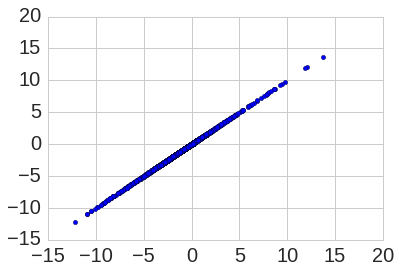

In [33]:
x, y = zip(*df[['ddg_h2o_clean', 'ddg_exp']].dropna().values)
plt.scatter(x, y)

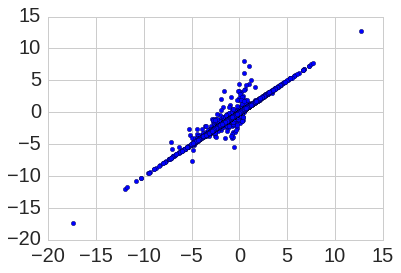

In [34]:
x, y = zip(*df[['ddg_clean', 'ddg_exp']].dropna().values)
plt.scatter(x, y)

# Save

In [36]:
db = datapkg.DataFrameToMySQL(CONNECTION_STR, NOTEBOOK_NAME, STG_SERVER_IP, echo=False)

In [37]:
df.head()

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_chain_sifts,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD,P00593,-,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N,P00593,H70N,A,H 48 N,6.5,NaN,NaN,-3.0,NaN,NaN,NaN,-3.0
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,NaN,NaN,NaN,NaN,NaN,NaN,1.34,6.60,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 Q,P00593,H70Q,A,H 48 Q,8.9,NaN,NaN,-0.6,NaN,NaN,NaN,-0.6
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,NaN,NaN,NaN,NaN,NaN,NaN,1.02,6.30,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 A,P00593,H70A,A,H 48 A,6.4,NaN,NaN,-3.1,NaN,NaN,NaN,-3.1
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN


In [38]:
db.import_table(
    df, 
    'protherm', [
        [('pdb_id', 'pdb_chain', 'pdb_mutation'), False],
        [('uniprot_id', 'uniprot_mutation'), False],
    ],
)

FML
FML
FML
FML


## Group

In [39]:
df[
    (df['pdb_id'] == '2rn2') & 
    (df['pdb_chain'] == '-') & 
    (df['pdb_mutation'] == 'WILD')
]

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_chain_sifts,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN
5,6,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,5.50,Sodium acetate,20 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,52.0,0.0,89.0,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"5,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,52.0,NaN,NaN,0,89.0,NaN
123,124,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A973992,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.20,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,53.0,0.0,99.2,NaN,NaN,NaN,NaN,NaN,yes,100%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Escherichia coli ribonuclease HI; thermal dena...,"J BIOL CHEM 272, 18686-18693 (1997) PMID: 9...","Akasako A, Haruki M, Oobatake M, Kanaya S",NaN,"125,126,127,128,129,130,131,132,133,134,135,13...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,53.0,NaN,NaN,0,99.2,NaN
141,142,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A960432,2RN2,NaN,wild,-,1,NaN,NaN,NaN,9.00,glycine-NaOH,50 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,47.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,yes,100%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Escherichia coli ribonuclease HI; thermal stab...,"J BIOL CHEM 271, 32729-32736 (1996) PMID: 8...","Kanaya S, Oobatake M, Liu Y",NaN,"143,144,145,146,147,148,149,150,151,152,153,15...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,47.0,NaN,NaN,0,NaN,NaN
142,143,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A960432,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,50.0,0.0,95.1,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Escherichia coli ribonuclease HI; thermal stab...,"J BIOL CHEM 271, 32729-32736 (1996) PMID: 8...","Kanaya S, Oobatake M, Liu Y",NaN,"142,144,145,146,147,148,149,150,151,152,153,15...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,-,NaN,NaN,NaN,NaN,50.0,NaN,NaN,0,95.1,NaN
382,383,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A910766,2RN2,NaN,wild,-,1,NaN,NaN,25.0,5.5,Sodium acetate,20 mM,NaCl,0.1 M,NaN,0.05 mg/ml,Fluorescence,GdnHCl,9.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.17,1.79,NaN,NaN,yes,NaN,0.11 (M13DNA.RNA hybrid); 0.53 (Nonanmicro cle...,100% (M13DNA.RNA hybrid); 100% (Nonanucleotide...,NaN,NaN,NaN,NaN,NaN,NaN,ribonuclease H; Escherichia coli; enzymatic ac...,"EUR J BIOCHEM 198, 437-440 (1991) PMID:...","Kanaya S., Katayanagi K., Morikawa K., Inoue H...",NaN,"384,3

In [40]:
print(datetime.datetime.now())

2016-05-05 19:14:30.817736
